In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing,SimpleExpSmoothing,Holt
from matplotlib import pyplot
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout


In [ ]:
train_data=pd.read_csv('/content/drive/MyDrive/ACV/ACV - Project/Project 3-Retail-Datasets-train_data/train_data.csv',index_col=2)
test_data=pd.read_csv('/content/drive/MyDrive/ACV/ACV - Project/Project 3-Retail-Datasets-train_data/test_data.csv',index_col=2)

<ipython-input-211-dcd278c5cf91>:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data=pd.read_csv('/content/drive/MyDrive/ACV/ACV - Project/Project 3-Retail-Datasets-train_data/train_data.csv',index_col=2)


In [ ]:
train_data.columns
test_data.columns

Index(['Store', 'DayOfWeek', 'Customers', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday'],
      dtype='object')

In [ ]:
train_timeseries=train_data['Sales']
train_timeseries.head

<bound method NDFrame.head of Date
2015-06-30     5735
2015-06-30     9863
2015-06-30    13261
2015-06-30    13106
2015-06-30     6635
              ...  
2013-01-01        0
2013-01-01        0
2013-01-01        0
2013-01-01        0
2013-01-01        0
Name: Sales, Length: 982644, dtype: int64>

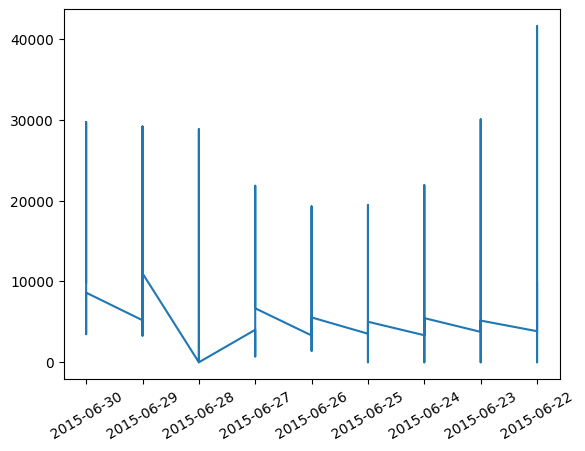

In [ ]:
#plot time series
plt.plot(train_timeseries[1:10000])
plt.xticks(rotation=30)
plt.show()

In [ ]:
#rolling average transform
rollingseries=train_timeseries[1:10000].rolling(window=500)
rollingmean=rollingseries.mean()
rollingmean.head

<bound method NDFrame.head of Date
2015-06-30         NaN
2015-06-30         NaN
2015-06-30         NaN
2015-06-30         NaN
2015-06-30         NaN
                ...   
2015-06-22    5868.028
2015-06-22    5867.816
2015-06-22    5860.294
2015-06-22    5861.722
2015-06-22    5862.638
Name: Sales, Length: 9999, dtype: float64>

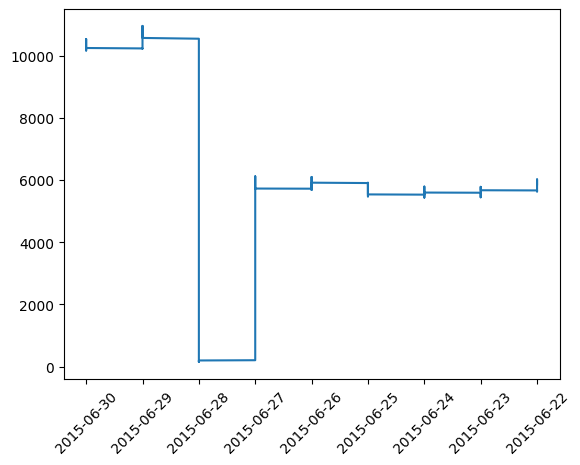

In [ ]:
plt.plot(rollingmean)
plt.xticks(rotation=45)
pyplot.show()

In [ ]:
#SimpleExponentialsmoothing
data=train_timeseries[1:5000]
fit1=SimpleExpSmoothing(data).fit(smoothing_level=0.2,optimized=False)
fit2=SimpleExpSmoothing(data).fit(smoothing_level=0.8,optimized=False)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


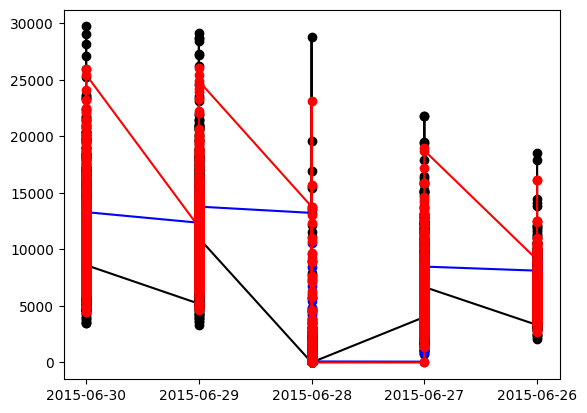

In [ ]:
plt.plot(data,marker='o',color='black')
plt.plot(fit1.fittedvalues,marker='o',color='blue')
plt.plot(fit2.fittedvalues,marker='o',color='red')

In [ ]:
#Holt method
fit1=Holt(data).fit()
#fit2=Holt(data,exponential=True).fit()



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


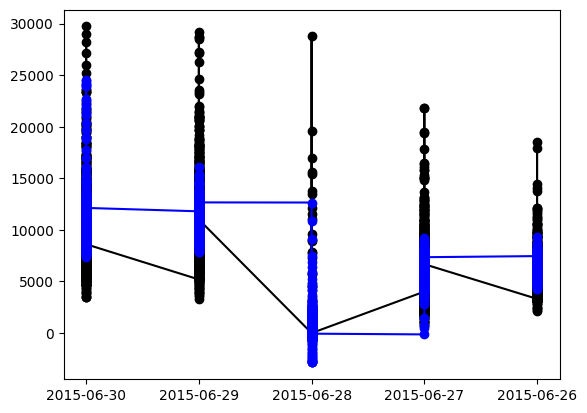

In [ ]:
plt.plot(data,marker='o',color='black')
plt.plot(fit1.fittedvalues,marker='o',color='blue')
#plt.plot(fit2.fittedvalues,marker='o',color='red')

In [ ]:
train_timeseries.head()
data1=train_timeseries.to_frame().reset_index(drop=True)

In [ ]:
data1.columns

Index(['Sales'], dtype='object')

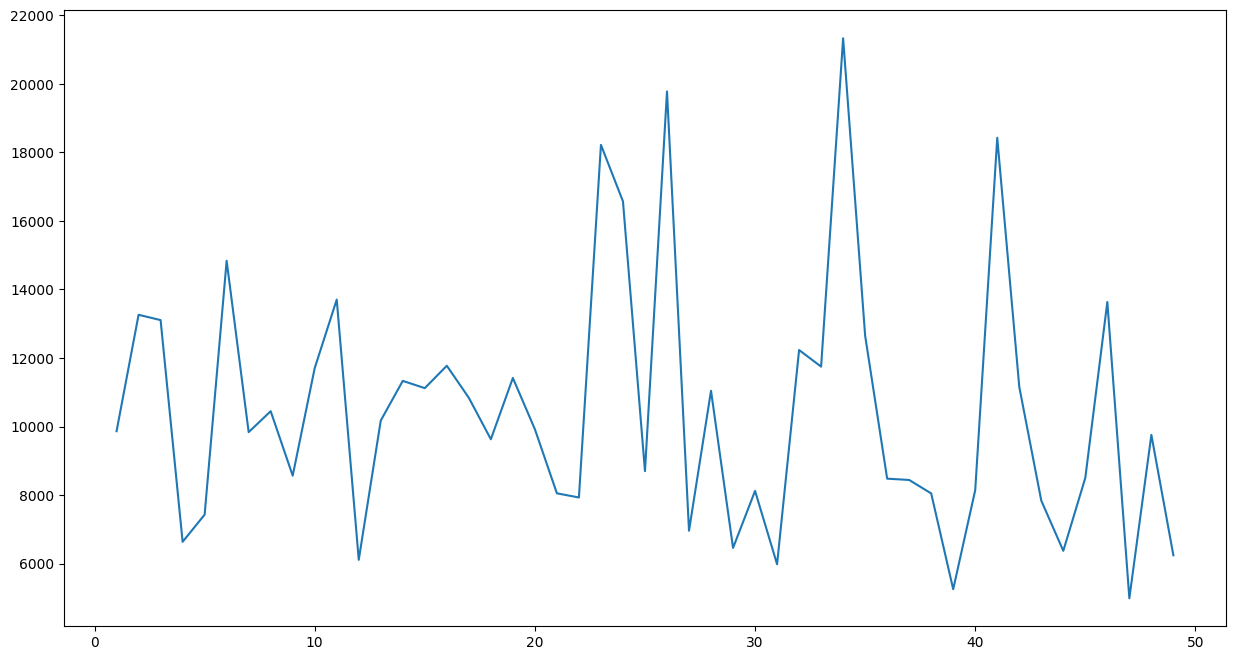

In [ ]:
from matplotlib import rcParams
plt.figure(figsize=(15,8))
plt.plot(data1[1:50])

In [ ]:
#multiplicative decomposition

#mul_result=seasonal_decompose(data1['Sales'],model='multiplicative',period=1)

#additive decomposition

add_result=seasonal_decompose(data1['Sales'][1:5000],model='additive',period=1)

Text(0.5, 0.98, '\n Addition Decompose')

<Figure size 5000x5000 with 0 Axes>

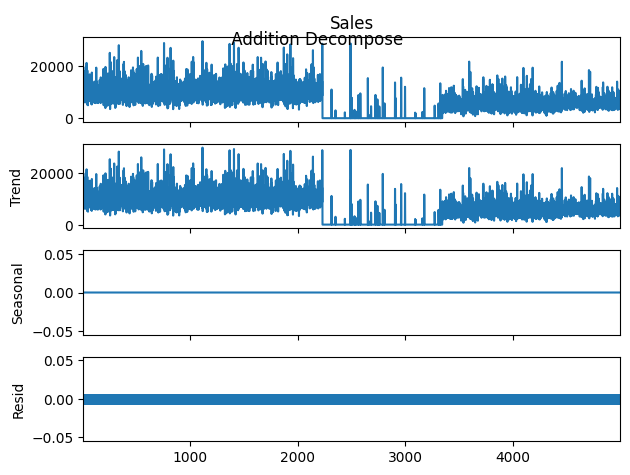

In [ ]:
plt.figure(figsize=(50,50))
#mul_result.plot().suptitle('\n Multiplication Decompose',fontsize=12)
add_result.plot().suptitle('\n Addition Decompose',fontsize=12)

In [ ]:
#stationarity check
adfuller_result=adfuller(data1[1:5000].values,autolag='AIC')
print(f'ADfuller statistic : {adfuller_result[0]}')
print(f'ADfuller p value : {adfuller_result[1]}')
print(adfuller_result)

ADfuller statistic : -2.0588586050716655
ADfuller p value : 0.2613761411515416
(-2.0588586050716655, 0.2613761411515416, 32, 4966, {'1%': -3.4316674956516784, '5%': -2.8621221897344484, '10%': -2.567079900452355}, 93733.81799826455)


In [ ]:
from statsmodels.tsa.stattools import acf,pacf
ACF_lag=acf(data1,nlags=200)


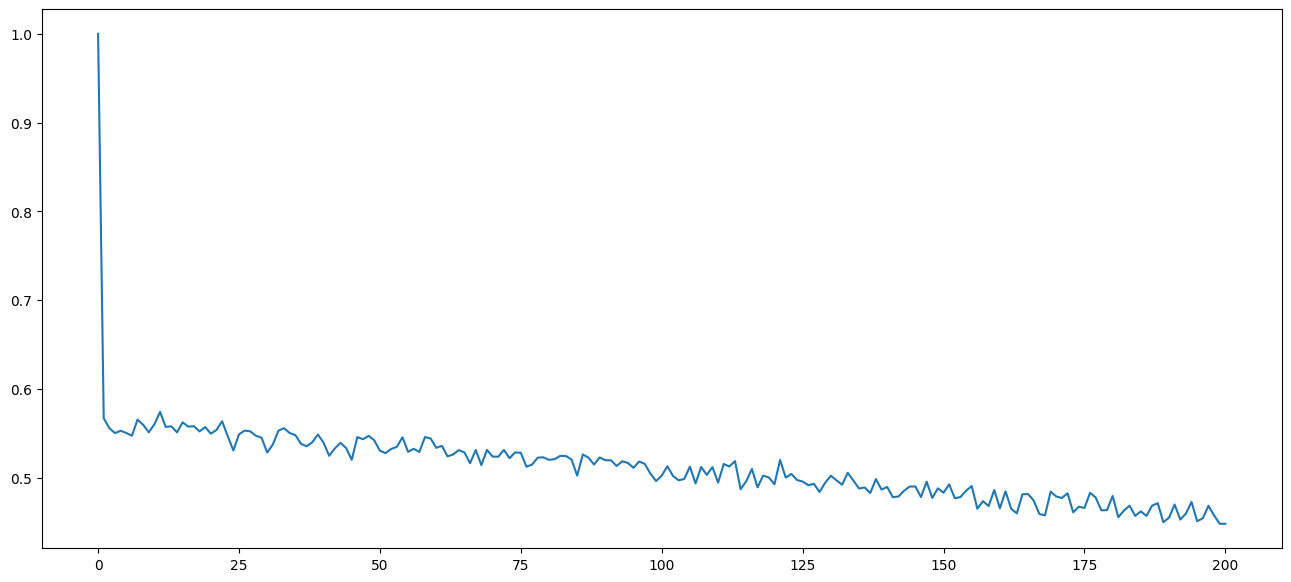

In [ ]:
#plot acf
plt.figure(figsize=(16,7))
plt.plot(ACF_lag)

In [ ]:
pacf_lag=pacf(data1,nlags=30,method='ols')


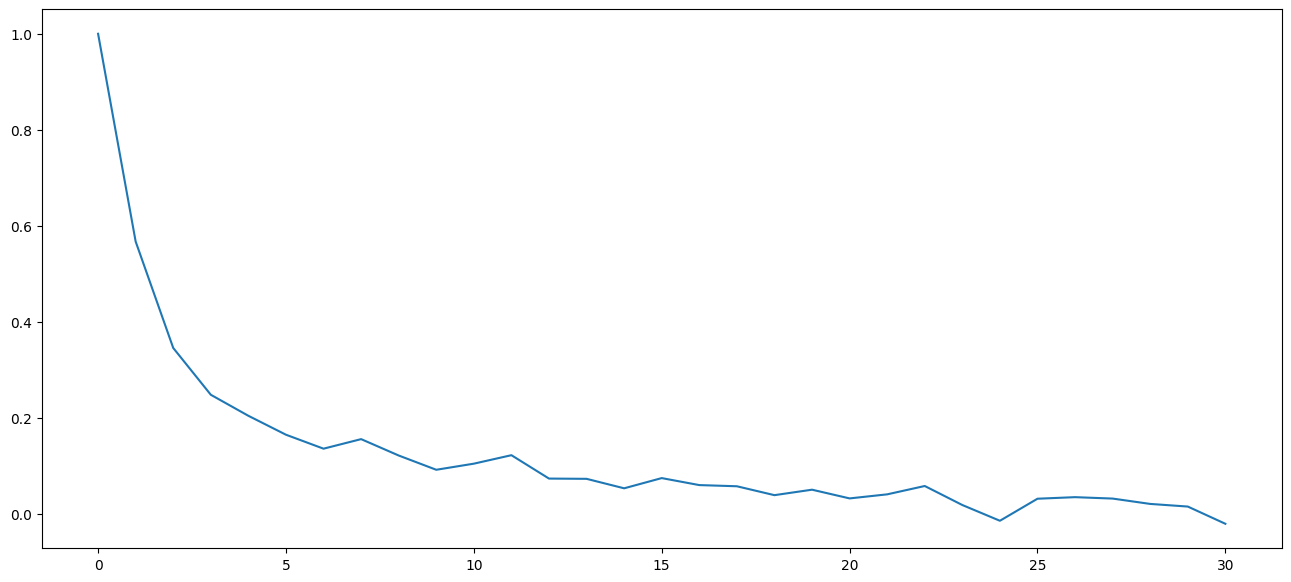

In [ ]:
#plot pacf
plt.figure(figsize=(16,7))
plt.plot(pacf_lag)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
data2=data1[1:1000]
arimamodel=ARIMA(data2['Sales'],order=(7,1,10))
arima_model_fit=arimamodel.fit()
y_pred=arima_model_fit.predict(len(data2),len(data2)+20,typ='levels')
print(y_pred)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1000     9886.791657
1001     9664.481748
1002    10635.645284
1003    10558.152291
1004     9986.111133
1005    10327.552270
1006    10565.998227
1007     9585.080773
1008    10592.397894
1009    10335.024532
1010    10001.736187
1011    10680.431626
1012    10309.830711
1013    10056.010776
1014    10386.256976
1015    10205.308541
1016     9976.044256
1017    10500.538586
1018    10323.753804
1019    10183.615656
1020    10565.446707
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [ ]:
y_act=data1[1000:1021]['Sales']

In [ ]:
from sklearn.metrics import mean_squared_error
mse=mean_squared_error(y_act,y_pred)
rmse=np.sqrt(mse)
rmse

3737.88295812071

In [ ]:
# import itertools
# i=j=range(0,4)
# ij=itertools.product(i,j)
# for parameters in ij:
#   try:
#     mod=ARMA(data2['Sales'],order=parameters)
#     result=mod.fit()
#     print("ARIMA{} AND AIC{}".format(parameters,result.aic))
#   except:
#     continue

In [ ]:
train_data.reset_index()
#test_data.dtypes

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,2015-06-30,1,2,5735,568,1,1,0,0
1,2015-06-30,2,2,9863,877,1,1,0,0
2,2015-06-30,3,2,13261,1072,1,1,0,1
3,2015-06-30,4,2,13106,1488,1,1,0,0
4,2015-06-30,5,2,6635,645,1,1,0,0
...,...,...,...,...,...,...,...,...,...
982639,2013-01-01,1111,2,0,0,0,0,a,1
982640,2013-01-01,1112,2,0,0,0,0,a,1
982641,2013-01-01,1113,2,0,0,0,0,a,1
982642,2013-01-01,1114,2,0,0,0,0,a,1


In [ ]:
train_data['StateHoliday']=train_data['StateHoliday'].astype(str)

In [ ]:
#Labelencoding
lenc=LabelEncoder()
lenc_train=lenc.fit_transform(train_data['StateHoliday'])
lenc_train=pd.DataFrame(lenc_train)
lenc_train.head


<bound method NDFrame.head of         0
0       0
1       0
2       0
3       0
4       0
...    ..
982639  1
982640  1
982641  1
982642  1
982643  1

[982644 rows x 1 columns]>

In [ ]:
train_data_enc=train_data.drop(columns='StateHoliday')
train_data_enc.reset_index(inplace=True, drop=True)
#train_data_enc.reset_index()
#lenc_train.columns

In [ ]:
train_data_1=pd.concat([train_data_enc,lenc_train],axis=1,)
#train_data_1.set_index(train_data_enc['Date'], inplace=True)
train_data_1.dtypes
train_data_1.shape


(982644, 8)

In [ ]:

train_data_1.shape
test_data.columns

Index(['Store', 'DayOfWeek', 'Customers', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday'],
      dtype='object')

In [ ]:
train_data_1.rename(columns={'0':'StateHoliday'},inplace=True)
type(train_data_1.columns)
train_data_1.columns = train_data_1.columns.astype(str)

In [ ]:
y_train=train_data_1['Sales']
train_data_1=train_data_1.drop(columns=['Sales'])

In [ ]:

y_train=pd.DataFrame(y_train)
y_train.shape
train_data_1.columns

Index(['Store', 'DayOfWeek', 'Customers', 'Open', 'Promo', 'SchoolHoliday',
       '0'],
      dtype='object')

In [ ]:
test_data.rename(columns={'StateHoliday': '0'}, inplace=True)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaler_x=scaler.fit(train_data_1)
scaled_xtrain=scaler_x.transform(train_data_1)
scaled_xtest = MinMaxScaler().fit_transform(test_data)
scaler_y = scaler.fit(y_train)
scaled_ytrain = scaler_y.transform(y_train)


In [ ]:
scaled_xtrain.shape
scaled_ytrain.shape

(982644, 1)

In [ ]:
trainX = []
trainY = []
n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14 #Number of past days we want to use to predict the future.
for i in range(n_past,len(scaled_xtrain)-n_future+1):
  trainX.append(scaled_xtrain[i-n_past:i,0:scaled_xtrain.shape[1]])
  trainY.append(scaled_ytrain[i+n_future-1:i+n_future])
trainX, trainY = np.array(trainX), np.array(trainY)
print(trainX.shape,trainY.shape)

(982630, 14, 7) (982630, 1, 1)


In [ ]:
#for generalisation
testX = []
n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14 #Number of past days we want to use to predict the future.
for i in range(n_past,len(scaled_xtest)-n_future+1):
  testX.append(scaled_xtest[i-n_past:i,0:scaled_xtest.shape[1]])
testX = np.array(testX)
print(testX.shape)

(34551, 14, 7)


In [ ]:
X_train,X_test,y_train,y_test=train_test_split(trainX,trainY,test_size=0.2,random_state=30)
X_train.shape

(786104, 14, 7)

In [ ]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 14, 64)            18432     
                                                                 
 lstm_11 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30881 (120.63 KB)
Trainable params: 30881 (120.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/5
4717/4717 [==============================] - 222s 46ms/step - loss: 0.0043 - val_loss: 0.0040
Epoch 2/5
4717/4717 [==============================] - 203s 43ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 3/5
4717/4717 [==============================] - 207s 44ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 4/5
4717/4717 [==============================] - 216s 46ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 5/5
4717/4717 [==============================] - 215s 45ms/step - loss: 0.0039 - val_loss: 0.0037


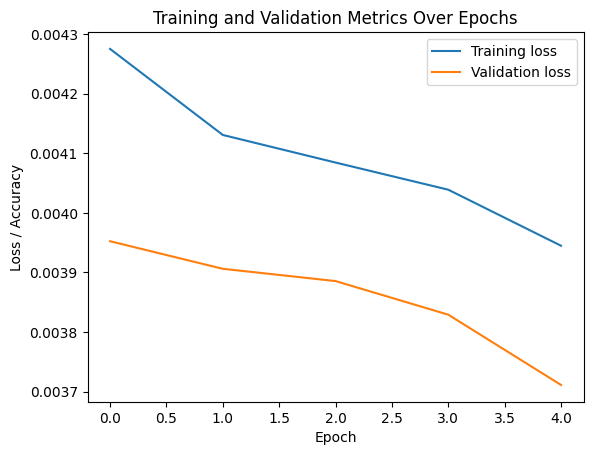

In [ ]:
history = model.fit(X_train, y_train, epochs=5, batch_size=150, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')

plt.plot(history.history['val_loss'], label='Validation loss')

#plt.plot(history.history['accuracy'], label='Training accuracy')
#plt.plot(history.history['val_accuracy'], label='Validation accuracy')

# Add labels and legend
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.title('Training and Validation Metrics Over Epochs')
plt.legend()
plt.show()

In [ ]:
#Validation prediction
train_predictions = model.predict(X_test)

6142/6142 [==============================] - 46s 7ms/step


In [ ]:
#Validation loss
#y_pred=scaler.inverse_transform(train_predictions)
validation_loss = model.evaluate(X_test, y_test)

6142/6142 [==============================] - 45s 7ms/step - loss: 0.0037


In [ ]:
print("Test Loss:", validation_loss)

Test Loss: 0.003721779678016901


In [ ]:
#generalization
test_predictions = model.predict(testX)
y_pred_test=scaler_y.inverse_transform(test_predictions)
y_pred_test

1080/1080 [==============================] - 8s 8ms/step


array([[ 451.40778],
       [ 966.6415 ],
       [ 969.2233 ],
       ...,
       [5589.321  ],
       [5392.8174 ],
       [3169.016  ]], dtype=float32)

In [ ]:
train_data.columns

NameError: ignored